In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Для моделирования
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# Указываем имя файла для загрузки
file_path = 'cat_dog.csv'

# Загружаем данные из CSV-файла в DataFrame
try:
    df = pd.read_csv(file_path)
    print(f"Файл '{file_path}' успешно загружен.")
except FileNotFoundError:
    print(f"Ошибка: Файл '{file_path}' не найден. Убедитесь, что он находится в той же папке, что и ваш Notebook.")
    # В случае ошибки, создаем пустой DataFrame, чтобы избежать дальнейших сбоев
    df = pd.DataFrame()

if not df.empty:
    # Посмотрим на первые 5 строк, чтобы убедиться, что все загрузилось правильно
    print("\nПервые 5 строк данных:")
    print(df.head())

    print("\nИнформация о данных:")
    df.info()

Файл 'cat_dog.csv' успешно загружен.

Первые 5 строк данных:
   active_sport  hours_outside  likes_active_leisure  likes_passive_leisure  \
0             1              8                     1                      0   
1             0             10                     0                      1   
2             1              7                     1                      1   
3             0              9                     0                      1   
4             1              6                     1                      0   

   travels_often  is_extrovert  is_introvert  lives_in_house  \
0              0             1             0               1   
1              1             0             1               0   
2              0             1             0               1   
3              0             0             1               0   
4              0             1             0               0   

   lives_in_apartment  park_nearby  has_children  wants_to_love  \
0           

In [3]:
# 1. Отделяем признаки (X) и целевую переменную (y)
X = df.drop('pet_preference', axis=1)
y_raw = df['pet_preference']

# 2. Преобразуем текстовые метки в числовые (cat -> 0, dog -> 1)
y = y_raw.map({'cat': 0, 'dog': 1})

# 3. Разделяем данные на обучающую и тестовую выборки (80% на обучение, 20% на тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Масштабируем признаки
# Это очень важный шаг для алгоритмов, основанных на расстоянии, таких как k-NN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Размер обучающей выборки: {X_train_scaled.shape}")
print(f"Размер тестовой выборки: {X_test_scaled.shape}")

Размер обучающей выборки: (44, 16)
Размер тестовой выборки: (11, 16)


Точность (Accuracy) модели: 1.00

Отчет по классификации:
              precision    recall  f1-score   support

   Cat Lover       1.00      1.00      1.00         5
   Dog Lover       1.00      1.00      1.00         6

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11


Матрица ошибок:


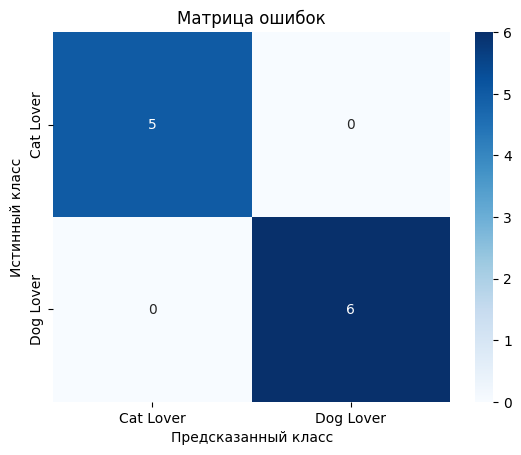

In [4]:
# Создаем экземпляр классификатора с k=5
knn = KNeighborsClassifier(n_neighbors=5)

# Обучаем модель на масштабированных обучающих данных
knn.fit(X_train_scaled, y_train)

# Делаем предсказания на тестовых данных
y_pred = knn.predict(X_test_scaled)

# Оцениваем качество модели
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность (Accuracy) модели: {accuracy:.2f}")

print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred, target_names=['Cat Lover', 'Dog Lover']))

print("\nМатрица ошибок:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat Lover', 'Dog Lover'], yticklabels=['Cat Lover', 'Dog Lover'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

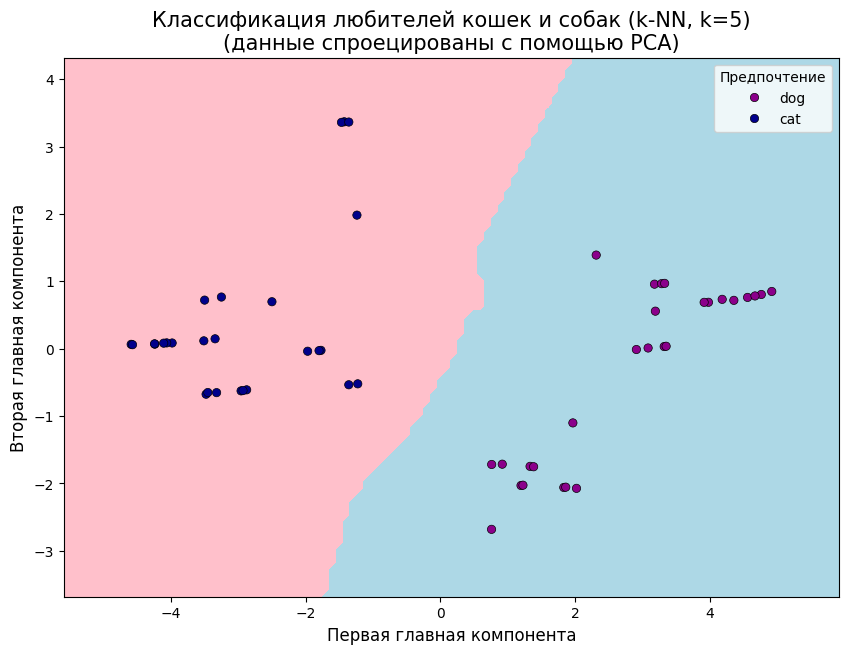

In [5]:
# Снижаем размерность всех данных до 2 компонент для визуализации
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaler.transform(X)) # Масштабируем все данные перед PCA

# Обучаем новую модель k-NN на 2D-данных, чтобы построить границу принятия решений
knn_2d = KNeighborsClassifier(n_neighbors=5)
knn_2d.fit(X_pca, y)

# Создаем сетку для построения графика
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Предсказываем класс для каждой точки на сетке
Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Цвета для графика
cmap_light = ListedColormap(['#FFC0CB', '#ADD8E6']) # Розовый для кошек, голубой для собак
cmap_bold = ['darkmagenta', 'darkblue']

# Рисуем график
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, cmap=cmap_light)

# Наносим на график точки из наших данных
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_raw,
                palette=cmap_bold, alpha=1.0, edgecolor="black")

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Классификация любителей кошек и собак (k-NN, k=5)\n(данные спроецированы с помощью PCA)", fontsize=15)
plt.xlabel("Первая главная компонента", fontsize=12)
plt.ylabel("Вторая главная компонента", fontsize=12)
plt.legend(title="Предпочтение")
plt.show()